# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: 7/15/2022
* Student Name: Tyler Valentine
* Student Net ID: xje4cy
* This URL: <https://github.com/Tyv132/Monte-Carlo-Simulator/blob/main/FinalProjectSubmission.ipynb>
* GitHub Repo URL: https://github.com/Tyv132/Monte-Carlo-Simulator

# The Monte Carlo Module

In [1]:
import random
import numpy as np
import pandas as pd

class Die: 
    '''
    Creates a die with n faces and weights, which can be rolled to select a face.
    Default value: 1.0 (float)     
    '''
    def __init__(self, faces):
        '''
        Input: faces (ndarray, str or floats) 
        '''
        weight = {'Weight': [1.0]*len(faces)}                                  # initializes all weights = 1
        self.__die = pd.DataFrame(weight, index = faces)                       # creates a private DataFrame for the die

    def change_weight(self, face, new_weight):
        '''
        Changes the weight of a face on the die to be the value "new_weight".
        Input: face (ndarray or list -str, int, or float), new_weight (float)
        '''
        if face in self.__die.index:
            try: 
                self.__die.loc[face] = float(new_weight)                       # changes the weight at the index "face"
            except:
                raise ValueError('The new weight must be of type float.')      # raises an error if the weight cannot be converted to a float
        else:
            raise ValueError('This face is not on the die.')                   # raises an error if the input is not a "face" on the die
    
    def roll(self, n = 1):
        '''
        Choose "n" random faces on the die.
        Input: n (int)
        Default value: 1 (int)
        Returns: n number of random faces on the die (list)
        '''      
        # chooses "n" random "faces" from the die according to the weights                                                              
        return random.choices(self.__die.index, k = n, weights = self.__die.Weight)                   

    def show(self):
        '''
        Show the current die, including the faces and their corresponding weights.
        Returns: Die (dataframe)
        '''
        return self.__die

class Game:
    '''
    Plays a game which consists of rolling one or more dice one or more times.
    '''
    def __init__(self, dice):
        '''
        Input: dice (list of Die objects)
        '''
        self.dice = dice 

    def play(self, n):
        '''
        Chooses a random face on each die "n" times and saves the results.
        Input: n (integer)
        '''
        results = []
        for n in range(n):
            roll = [Die.roll(die)[0] for die in self.dice]                     # calls the "roll" function and creates a list
            results.append(roll)                                               # of the results from "n" rolls for each die

        # save results to a private dataframe
        __columns = list(range(0,len(self.dice)))                              # defines the column names
        self.__outcome = pd.DataFrame(results, columns = __columns)            # creates a dataframe from the list of results
        self.__outcome.index = list(range(0,len(self.__outcome)))              # defines the index for the dataframe 
        self.__outcome.index.name = 'Roll'                                     # names the row index "Roll"
        self.__outcome.columns.name = 'Die'                                    # names the column index "Die"

    def show(self, form = "wide"):
        '''
        Shows the outcome of the most recent play as a dataframe in either "wide" or "narrow" form.
        Input: form ("wide" or "narrow" strings)
        Default value: "wide" (string)
        Returns: outcome (dataframe)
        '''
        if form == "wide":
            return self.__outcome                                              # returns the dataframe in wide form 
        elif form == "narrow":
            return self.__outcome.stack().to_frame("Face rolled")              # returns the dataframe in narrow form 
        else:
            raise ValueError('The form must be "wide" or "narrow"')            # raises an error if the form input is invalid

class Analyzer: 
    '''
    Takes the results of a game and returns the number of jackpots, 
    the combinations of "faces", and the "face" counts for each roll. 
    '''
    def __init__(self, game):
        '''
        Input: dice (list of Die objects)
        '''
        self.__game = game                                                     # defines game object                         
        self.__outcome = game.show()                                           # defines outcome of game 
    
    def jackpot(self): 
        '''
        Computes how many times the game resulted in all faces being identical.
        Attribute: analyzer.jackpots (dataframe)
        '''
        self.jackpots = self.__outcome.copy()                                  # creates a copy of the outcome dataframe
        count = 0                                                              # initializes the jackpot count to be zero

        for row in range(0, len(self.jackpots)):                               # steps through each row in the outcome dataframe
            if len(set(self.jackpots.loc[row])) != 1:                          # if all of the "faces" are not equal,
                self.jackpots = self.jackpots.drop([row])                      # that row is dropped from the dataframe
            else:
                count += 1                                                     # otherwise, add 1 jackpot to the total count
        return count                                                           # display the total number of jackpots

    def combo(self):
        '''
        Computes the distinct combinations of faces rolled, along with their counts.
        Attribute: analyzer.combos (dataframe) 
        '''
        # sorts the columns and saves the combinations and their counts  
        combos = self.__outcome.copy() 
        self.combos = combos.apply(lambda x: pd.Series(sorted(x)),1).value_counts().to_frame('Counts')           
                                                                      
    def face_count(self):
        '''
        Computes how many times a given "face" is rolled in each game
        Attribute: analyzer.face_counts (dataframe)
        '''
        faces = self.__game.dice[0].show().index.values.tolist()               # defines the list of "faces"
        self.face_counts = pd.DataFrame(columns = faces)                       # creates a dataframe with the "faces" as columns
        for row in range(0, len(self.__outcome)):                              # for each row in the outcome dataframe,
            add_row = self.__outcome.loc[row].value_counts().to_frame().T      # defines a row with the count of unique "faces"
            self.face_counts = pd.concat([self.face_counts, add_row], axis=0)  # adds the defined row to the face_counts dataframe
        self.face_counts = self.face_counts.fillna(0)                          # changes the face_counts NaN values to be zero

# Test Module

In [2]:
import unittest
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from montecarlo import Die, Game, Analyzer

class MontecarloTestSuite(unittest.TestCase):
    '''
    Tests the classes containted in the module "montecarlo". 
    '''
    def test_1_change_weight(self):
        '''
        Tests the Die.change_weight() function.
        '''
        # create die instance
        die = Die([1,2,3,4,5,6])
        # change weight
        die.change_weight(1,3)
        # check
        actual = die.show()
        expected = pd.DataFrame({'Weight': [3.0,1.0,1.0,1.0,1.0,1.0]}, \
                                   index = [1,2,3,4,5,6])
        pd.testing.assert_frame_equal(actual, expected) 

    def test_2_roll(self):
        '''
        Tests the Die.roll() function. 
        '''
        # create die instance
        die = Die([1,2,3,4,5,6])
        # roll
        roll = die.roll()
        # check
        actual = 1 <= roll[0] <= 6
        message = "Test value is not True."
        self.assertTrue(actual, message)

    def test_3_show(self):
        '''
        Tests the Die.show() function. 
        '''
        # create die instance
        die = Die([1,2,3,4,5,6])
        # check 
        actual = die.show()
        expected = pd.DataFrame({'Weight': [1.0,1.0,1.0,1.0,1.0,1.0]}, index = [1,2,3,4,5,6])
        pd.testing.assert_frame_equal(actual, expected)

# GAME TESTS 
    def test_4_play(self):
        '''
        Tests the Game.play() function. 
        '''
        # create game instance
        die1 = Die([1,2,3,4,5,6])
        die2 = Die([1,2,3,4,5,6])
        game = Game([die1, die2])
        # play
        game.play(3)
        result = game.show()
        # check 
        actual = np.shape(result.values)
        expected = (3,2) 
        self.assertEqual(actual, expected)

    def test_5_show(self): 
        '''
        Tests the Game.show() function. 
        '''
        # create game instance
        die1 = Die([1,2,3,4,5,6])
        die2 = Die([1,2,3,4,5,6])
        game = Game([die1, die2])
        game.play(5)
        result = game.show()
        # check 
        actual = np.shape(result.values)
        expected = (5,2)
        self.assertEqual(actual, expected)

# ANALYZER TESTS 
    def test_6_jackpot(self):
        '''
        Tests the Analyzer.jackpot() function. 
        '''
        # create analyzer instance 
        die1 = Die([1,2,3,4,5,6])
        die2 = Die([1,2,3,4,5,6])
        game = Game([die1, die2])
        game.play(50)
        analyzer = Analyzer(game)
        # find jackpots 
        analyzer.jackpot()
        jackpots = analyzer.jackpots
        list = jackpots.values.tolist()
        # check 
        actual = 0
        for i in range(0,len(list)):        
            if all(x == list[i][0] for x in list[i]) == True:
                actual += 1 
        expected = len(list)
        self.assertEqual(actual, expected) 

    def test_7_combo(self):
        '''
        Tests the Analyzer.combo() function.
        '''
        # create analyzer instance
        die1 = Die([1,2,3,4,5,6])
        die2 = Die([1,2,3,4,5,6])
        game = Game([die1, die2])
        game.play(50)
        analyzer = Analyzer(game) 
        # find combos
        analyzer.combo()
        combos = analyzer.combos
        list = combos.index.tolist()
        # check 
        actual = sorted(set(item for item in list))
        expected = sorted(list)
        self.assertEqual(actual, expected) 

    def test_8_face_count(self):
        '''
        Tests the Analyzer.face_count() function. 
        '''
        # create analyzer instance
        die1 = Die([1,2,3])
        die2 = Die([1,2,3])
        game = Game([die1, die2])
        game.play(10)
        analyzer = Analyzer(game)
        # find face_count
        analyzer.face_count()
        list = analyzer.face_counts.values
        # check
        actual = 0 
        for i in range(0,len(list)):        
            if sum(list[i]) == 2:
                actual += 1 
        expected = len(list)
        self.assertEqual(actual, expected) 

#if __name__ == '__main__':
#    unittest.main(verbosity=3)

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

In [3]:
from montecarlo import Die, Game, Analyzer

## Scenario 1: A 2-headed coin

---
Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.

In [4]:
fair = Die(['H', 'T'])
unfair = Die(['H','T'])
unfair.change_weight('H', 5)

In [5]:
fair.show()

,Weight
H,1.0
T,1.0


In [6]:
unfair.show()

,Weight
H,5.0
T,1.0


---
Play a game of 1000 flips of three coins with all fair dice.

In [7]:
fair_game = Game([fair, fair, fair])
fair_game.play(1000)
fair_game.show()

Die,0,1,2
Roll,,,
0,H,T,H
1,H,T,H
2,T,H,T
3,H,H,H
4,H,T,H
...,...,...,...
995,T,H,H
996,H,T,H
997,H,T,H


---
Play a game of 1000 flips with two unfair dice and one fair die.

In [8]:
unfair_game = Game([unfair, unfair, fair])
unfair_game.play(1000)
unfair_game.show()

Die,0,1,2
Roll,,,
0,H,H,H
1,H,H,T
2,H,H,T
3,H,H,T
4,H,T,H
...,...,...,...
995,H,H,H
996,H,H,T
997,H,H,T


---
For each game, use an Analyzer object to determine the relative frequency of jackpots – getting either all Hs or all Ts.

In [9]:
fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_frq = fair_analyzer.jackpot() / 1000
unfair_frq = unfair_analyzer.jackpot() / 1000

print('Relative frequency of jackpots for the fair game:', fair_frq)
print('Relative frequency of jackpots for the unfair game:', unfair_frq)

Relative frequency of jackpots for the fair game: 0.246
Relative frequency of jackpots for the unfair game: 0.365


---
Show your results, comparing the two relative frequencies, in a simple bar chart.

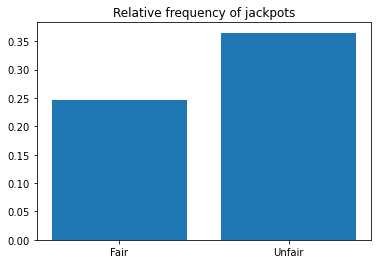

In [10]:
import matplotlib.pyplot as plt
plt.bar(['Fair', 'Unfair'],[fair_frq, unfair_frq]);
plt.title('Relative frequency of jackpots');

## Scenario 2: A 6-sided die

---
Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will  weight 1 five times more than the others.

In [11]:
fair = Die([1, 2, 3, 4, 5, 6])
fair.show()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


In [12]:
unfair1 = Die([1, 2, 3, 4, 5, 6])
unfair1.change_weight(6, 5)
unfair1.show()

,Weight
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,5.0


In [13]:
unfair2 = Die([1, 2, 3, 4, 5, 6])
unfair2.change_weight(1, 5)
unfair2.show()

,Weight
1,5.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


---
Play a game of 10000 rolls with 5 fair dice. 

Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair die of type 2, and the rest fair dice.

In [14]:
fair_game = Game([fair, fair, fair, fair, fair])
fair_game.play(10000)

unfair_game = Game([unfair1, unfair1, unfair2, fair, fair])
unfair_game.play(10000)

---
For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

In [15]:
fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_frq = fair_analyzer.jackpot() / 1000
unfair_frq = unfair_analyzer.jackpot() / 1000

print('Relative frequency of jackpots for the fair game:', fair_frq)
print('Relative frequency of jackpots for the unfair game:', unfair_frq)

Relative frequency of jackpots for the fair game: 0.01
Relative frequency of jackpots for the unfair game: 0.006


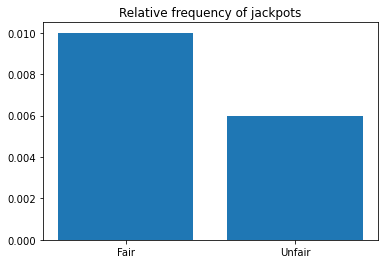

In [16]:
plt.bar(['Fair', 'Unfair'],[fair_frq, unfair_frq])
plt.title('Relative frequency of jackpots');

---
Also compute 10 most frequent combinations of faces for each game. Plot each of these as bar charts.

In [17]:
fair_analyzer.combo()
unfair_analyzer.combo()

In [18]:
fair_analyzer.combos.head(10)

Counts
0 1 2 3 4        
1 2 3 5 6     165
      4 6     155
  3 4 5 6     148
  2 4 5 6     143
2 3 4 5 6     141
1 2 3 4 5     141
      3 6      91
  1 2 3 5      90
    3 5 6      89
3 3 4 5 6      89

In [19]:
unfair_analyzer.combos.head(10)

Counts
0 1 2 3 4        
1 3 4 6 6     214
    5 6 6     213
  4 5 6 6     207
  2 3 6 6     205
    5 6 6     203
    4 6 6     193
    3 5 6     182
    4 5 6     181
  3 4 5 6     177
  1 4 6 6     166

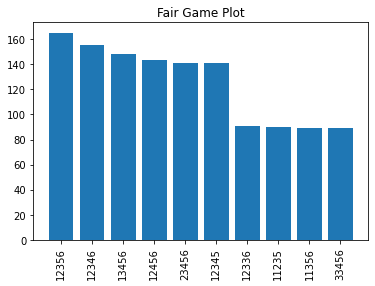

In [20]:
fair_plot = fair_analyzer.combos.head(10).reset_index()
fair_plot["labels"] = fair_plot[0].astype(str) + fair_plot[1].astype(str) + fair_plot[2].astype(str) \
                + fair_plot[3].astype(str) + fair_plot[4].astype(str)
fair_plot = fair_plot[['Counts', 'labels']]
plt.bar(fair_plot['labels'],fair_plot['Counts'])
plt.xticks(rotation='vertical');
plt.title("Fair Game Plot");

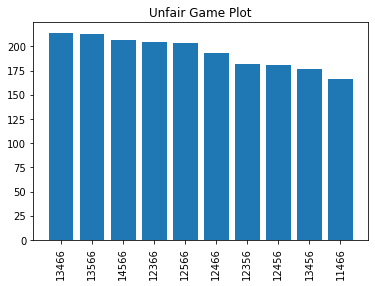

In [21]:
unfair_plot = unfair_analyzer.combos.head(10).reset_index()
unfair_plot["labels"] = unfair_plot[0].astype(str) + unfair_plot[1].astype(str) + unfair_plot[2].astype(str) \
                + unfair_plot[3].astype(str) + unfair_plot[4].astype(str)
unfair_plot = unfair_plot[['Counts', 'labels']]
plt.bar(unfair_plot['labels'],unfair_plot['Counts'])
plt.xticks(rotation='vertical');
plt.title("Unfair Game Plot");

## Scenario 3: A 6-sided die

---
Create a "die" of letters from a to z with weights based on their frequency of usage.

In [22]:
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p',
           'q','r','s','t','u','v','w','x','y','z']
values = [8.4966, 2.0720, 4.5388, 3.3844, 11.1607, 1.8121, 2.4705, 3.0034, 7.5448, 
          0.1965, 1.1016, 5.4893, 3.0129, 6.6544, 7.1635, 3.1671, 0.1962, 7.5809, 5.7351,
          6.9509, 3.6308, 1.0074, 1.2899, 0.2902, 1.7779, 0.2722]

alphabet = Die(letters)
for i in range(0,len(letters)):
    alphabet.change_weight(letters[i], values[i])

In [23]:
alphabet.show().T

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
Weight,8.4966,2.072,4.5388,3.3844,11.1607,1.8121,2.4705,3.0034,7.5448,0.1965,...,0.1962,7.5809,5.7351,6.9509,3.6308,1.0074,1.2899,0.2902,1.7779,0.2722


---
Play a game involving 5 of these dice with 1000 rolls.

In [24]:
alphabet_game = Game([alphabet, alphabet, alphabet, alphabet, alphabet])
alphabet_game.play(1000)

In [25]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

---
How many combos can you see that look like actual English words?

I found the following words: teeny, saint, coder,  peeks, peel, terf, night. \
It appears that words with consecutive vowels, such as e's, are more common. 

In [26]:
alphabet_game.show().T # transposed to save space

Roll,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Die,,,,,,,,,,,,,,,,,,,,,
0,a,e,s,i,e,h,l,a,r,r,...,g,v,v,u,l,a,d,e,l,a
1,a,e,e,l,t,l,s,s,b,e,...,n,b,e,k,n,l,l,h,u,i
2,s,u,e,a,a,s,p,r,o,n,...,l,u,a,s,d,r,d,e,g,r
3,m,a,i,i,i,d,o,f,u,a,...,l,r,t,u,l,p,c,i,a,h
4,x,d,k,i,a,b,i,o,e,t,...,s,e,o,i,w,i,f,w,l,b


# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [27]:
!ls -lRF -o

.:
total 205
-rw-r--r-- 1 Tyv13 97709 Jul 15 10:34 FinalProjectSubmission.ipynb
-rw-r--r-- 1 Tyv13  1095 Jul 13 22:05 LICENSE
drwxr-xr-x 1 Tyv13     0 Jul 13 22:10 montecarlo/
drwxr-xr-x 1 Tyv13     0 Jul 15 10:28 montecarlo.egg-info/
-rw-r--r-- 1 Tyv13 77563 Jul 14 23:30 montecarlo_demo.ipynb
-rw-r--r-- 1 Tyv13  4295 Jul 14 23:31 montecarlo_tests.py
-rw-r--r-- 1 Tyv13   822 Jul 13 16:17 montecarlo_tests.txt
-rw-r--r-- 1 Tyv13  6516 Jul 15 10:09 README.md
-rw-r--r-- 1 Tyv13   347 Jul 13 22:05 setup.py

./montecarlo:
total 13
-rw-r--r-- 1 Tyv13   53 Jul 13 22:15 __init__.py
drwxr-xr-x 1 Tyv13    0 Jul 15 09:04 __pycache__/
-rw-r--r-- 1 Tyv13 6989 Jul 15 09:02 montecarlo.py

./montecarlo/__pycache__:
total 9
-rw-r--r-- 1 Tyv13  241 Jul 14 09:10 __init__.cpython-39.pyc
-rw-r--r-- 1 Tyv13 5325 Jul 15 09:04 montecarlo.cpython-39.pyc

./montecarlo.egg-info:
total 4
-rw-r--r-- 1 Tyv13   1 Jul 15 10:28 dependency_links.txt
-rw-r--r-- 1 Tyv13 317 Jul 15 10:28 PKG-INFO
-rw-r--r-- 1 Tyv13 210 Jul

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [28]:
pip install -e .

Obtaining file:///C:/Users/Tyv13/Desktop/Monte-Carlo-SimulatorNote: you may need to restart the kernel to use updated packages.

  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 1.0
    Uninstalling montecarlo-1.0:
      Successfully uninstalled montecarlo-1.0
  Running setup.py develop for montecarlo
